In [296]:
#DATABASE CREATION AND SYNTETIC DATA
import sqlite3
import pandas as pd
import numpy as np
from faker import Faker
import random

fake = Faker()
Faker.seed(42)
np.random.seed(42)
random.seed(42)

# Connect to SQLite 
conn = sqlite3.connect("synthetic_recommendation.db")
cursor = conn.cursor()

# --- Step 1: Create SQL Tables ---
create_sql = """
CREATE TABLE IF NOT EXISTS customer_profile (
    CustomerID TEXT PRIMARY KEY,
    CustomerTypeCode TEXT,
    ProfitCentre INTEGER,
    LOR_Months INTEGER,
    Gender TEXT,
    Age INTEGER,
    MaritalStatus TEXT,
    Income INTEGER,
    Emirate TEXT,
    NationalityRegion TEXT,
    Flag_SalaryTransfer TEXT
);

CREATE TABLE IF NOT EXISTS product_summary (
    CustomerID TEXT PRIMARY KEY,
    CC_Limit INTEGER,
    CC_SpendVolume INTEGER,
    DBR_Internal REAL,
    MO_Disbursed INTEGER,
    AL_Disbursed INTEGER,
    PL_Disbursed INTEGER,
    SL_Disbursed INTEGER,
    MO_Balance INTEGER,
    AL_Balance INTEGER,
    PL_Balance INTEGER,
    SL_Balance INTEGER,
    MO_Count INTEGER,
    AL_Count INTEGER,
    PL_Count INTEGER,
    SL_Count INTEGER,
    Total_FD_Count INTEGER,
    Total_FD_Balance INTEGER,
    Total_CASA_Count INTEGER,
    Total_AVG_CASA_BALANCE INTEGER,
    TOTAL_Products INTEGER
);

CREATE TABLE IF NOT EXISTS mcc_category (
    MCC INTEGER PRIMARY KEY,
    MCC_Name TEXT,
    MCG_Name TEXT,
    Period TEXT
);

CREATE TABLE IF NOT EXISTS transactions (
    CustomerID TEXT,
    TxnDate TEXT,
    Category TEXT,
    BillingAmount REAL,
    TxnLoc TEXT,
    MercCountry TEXT,
    Gateway TEXT,
    Channel TEXT,
    MCC INTEGER,
    Description TEXT,
    AcquirerBin INTEGER
);
"""
cursor.executescript(create_sql)


In [ ]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from sqlalchemy import create_engine
from datetime import datetime, timedelta

fake = Faker()
np.random.seed(42)
random.seed(42)

# SQLite connection
conn = create_engine('sqlite:///synthetic_recommendation.db')

# Parameters
num_customers = 1000
customer_ids = [f'CUST{str(i).zfill(4)}' for i in range(1, num_customers + 1)]
num_mcc = 800
num_transactions = 8000

# Helper functions
def add_nulls(df, null_fraction=0.05):
    df = df.copy()
    for col in df.columns:
        mask = np.random.rand(len(df)) < null_fraction
        df.loc[mask, col] = np.nan
    return df

# 1. Customer Profile
customer_profile = pd.DataFrame({
    'CustomerID': customer_ids,
    'CustomerTypeCode': np.random.choice(['R', 'P', 'S', 'GOLD', 'PLATINUM'], size=num_customers),
    'ProfitCentre': np.random.choice(range(1000, 1100), size=num_customers),
    'LOR_Months': np.random.randint(1, 240, size=num_customers),
    'Gender': np.random.choice(['M', 'F', 'Other', 'Prefer not to say'], size=num_customers),
    'Age': np.random.randint(18, 80, size=num_customers),
    'MaritalStatus': np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'], size=num_customers),
    'Income': np.random.randint(3000, 100000, size=num_customers),
    'Emirate': np.random.choice(['DXB', 'AUH', 'SHJ', 'AJM', 'RAK', 'FJR', 'UAQ'], size=num_customers),
    'NationalityRegion': np.random.choice(
        ['MENA', 'South Asia', 'Europe', 'Africa', 'East Asia', 'Americas'], size=num_customers
    ),
    'Flag_SalaryTransfer': np.random.choice(['Y', 'N'], size=num_customers)
})
customer_profile = add_nulls(customer_profile, 0.05)
customer_profile.drop_duplicates('CustomerID', inplace=True)
customer_profile.to_sql('customer_profile', conn, if_exists='replace', index=False)

# 2. Product Summary
product_summary = pd.DataFrame({
    'CustomerID': customer_ids,
    'CC_Limit': np.random.randint(5000, 150000, size=num_customers),
    'CC_SpendVolume': np.random.randint(1000, 100000, size=num_customers),
    'DBR_Internal': np.round(np.random.uniform(0.05, 1.0, size=num_customers), 2),
    'MO_Disbursed': np.random.randint(0, 200000, size=num_customers),
    'AL_Disbursed': np.random.randint(0, 150000, size=num_customers),
    'PL_Disbursed': np.random.randint(0, 100000, size=num_customers),
    'SL_Disbursed': np.random.randint(0, 50000, size=num_customers),
    'MO_Balance': np.random.randint(0, 150000, size=num_customers),
    'AL_Balance': np.random.randint(0, 100000, size=num_customers),
    'PL_Balance': np.random.randint(0, 80000, size=num_customers),
    'SL_Balance': np.random.randint(0, 30000, size=num_customers),
    'MO_Count': np.random.randint(0, 4, size=num_customers),
    'AL_Count': np.random.randint(0, 4, size=num_customers),
    'PL_Count': np.random.randint(0, 4, size=num_customers),
    'SL_Count': np.random.randint(0, 3, size=num_customers),
    'Total_FD_Count': np.random.randint(0, 6, size=num_customers),
    'Total_FD_Balance': np.random.randint(0, 200000, size=num_customers),
    'Total_CASA_Count': np.random.randint(1, 5, size=num_customers),
    'Total_AVG_CASA_BALANCE': np.random.randint(1000, 80000, size=num_customers),
    'TOTAL_Products': np.random.randint(1, 12, size=num_customers)
})
product_summary = add_nulls(product_summary, 0.05)
product_summary.drop_duplicates('CustomerID', inplace=True)
product_summary.to_sql('product_summary', conn, if_exists='replace', index=False)

# 3. MCC Categories
mcc_codes = random.sample(range(1000, 9999), num_mcc)
mcc_category = pd.DataFrame({
    'MCC': mcc_codes,
    'MCC_Name': [fake.company() for _ in range(num_mcc)],
    'MCG_Name': np.random.choice(
        ['Retail', 'Food', 'Travel', 'Entertainment', 'Health', 'Electronics', 'Automotive'], size=num_mcc
    ),
    'Period': [f"202{random.randint(0, 4)}-Q{random.randint(1, 4)}" for _ in range(num_mcc)]
})
mcc_category.to_sql('mcc_category', conn, if_exists='replace', index=False)

# 4. Customer preference profiles
cat_list = ['Retail', 'Food', 'Travel', 'Entertainment', 'Health', 'Electronics', 'Automotive']
customer_cat_pref = pd.DataFrame(
    np.random.dirichlet([1]*len(cat_list), size=num_customers),
    columns=cat_list,
    index=customer_ids
)

# 5. Transactions
transactions = []
for cust in customer_ids:
    n_tx = np.random.poisson(lam=25) + 5
    prefs = customer_cat_pref.loc[cust]
    tx_cats = np.random.choice(cat_list, p=prefs, size=n_tx)

    for cat in tx_cats:
        transactions.append({
            'CustomerID': cust,
            'TxnDate': fake.date_between(start_date='-1y', end_date='today'),
            'Category': cat,
            'BillingAmount': round(np.random.lognormal(mean=3, sigma=0.8), 2),
            'TxnLoc': fake.city(),
            'MercCountry': fake.country_code(),
            'Gateway': np.random.choice(['VISA', 'MasterCard', 'AMEX', 'UPI', 'ApplePay']),
            'Channel': np.random.choice(['Online', 'POS', 'Mobile', 'ATM']),
            'MCC': np.random.choice(mcc_codes),
            'Description': fake.catch_phrase(),
            'AcquirerBin': np.random.randint(100000, 999999)
        })

transactions_df = pd.DataFrame(transactions)
transactions_df = add_nulls(transactions_df, 0.03)
transactions_df.drop_duplicates(inplace=True)
transactions_df.to_sql('transactions', conn, if_exists='replace', index=False)



✅ Synthetic data generated with more realistic variety.


In [298]:
# Check a few records from the transactions table
df = pd.read_sql_query("SELECT * FROM transactions LIMIT 5;", conn)
print(df)


  CustomerID     TxnDate       Category  BillingAmount             TxnLoc  \
0   CUST0001  2024-07-06    Electronics          45.82  West Jeffreyhaven   
1   CUST0001  2024-09-25  Entertainment          46.07        Brooksmouth   
2   CUST0001  2024-08-29  Entertainment          61.59        Whitneyfort   
3   CUST0001  2024-08-16  Entertainment          26.92         West Larry   
4   CUST0001  2024-11-14         Health          28.80         Davismouth   

  MercCountry   Gateway Channel     MCC  \
0          TH       UPI  Online  5844.0   
1          GD  ApplePay     ATM  5462.0   
2          CA       UPI     ATM  5415.0   
3          PH  ApplePay  Online  3103.0   
4          LB      None  Mobile  8428.0   

                                      Description  AcquirerBin  
0             Reduced system-worthy orchestration     501938.0  
1     Reverse-engineered system-worthy middleware     103089.0  
2  Implemented intangible artificial intelligence     618256.0  
3                 

Data Exploration


In [299]:
conn = sqlite3.connect("synthetic_recommendation.db")

# Load required tables
transactions_df = pd.read_sql_query("SELECT * FROM transactions", conn)
customers_df = pd.read_sql_query("SELECT * FROM customer_profile", conn)
cards_df = pd.read_sql_query("SELECT * FROM product_summary", conn)
mcc_df = pd.read_sql_query("SELECT * FROM mcc_category", conn)

Total Transactions: 30078

Transactions per Customer:
 count    1000.000000
mean       29.171000
std         4.946132
min        14.000000
25%        26.000000
50%        29.000000
75%        33.000000
max        45.000000
dtype: float64

Billing Amount Summary:
 count    29152.000000
mean        27.457454
std         25.972286
min          0.970000
25%         11.697500
50%         20.080000
75%         34.080000
max        858.840000
Name: BillingAmount, dtype: float64


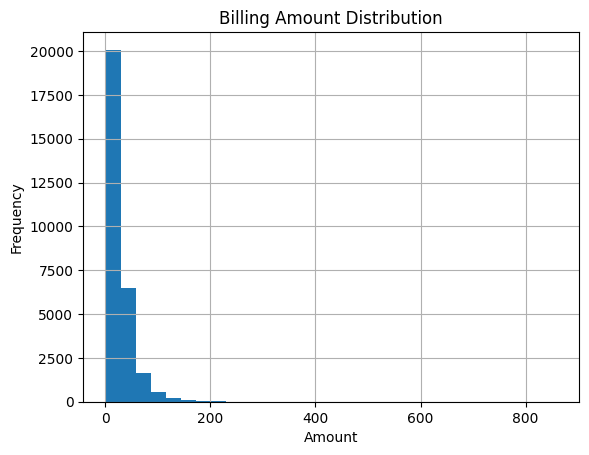

In [300]:
# Total transaction volume
total_txns = len(transactions_df)
print(f"Total Transactions: {total_txns}")

# Transactions per customer
txns_per_customer = transactions_df.groupby('CustomerID').size().describe()
print("\nTransactions per Customer:\n", txns_per_customer)

# Billing amount distribution
print("\nBilling Amount Summary:\n", transactions_df['BillingAmount'].describe())

# Histogram (optional visualization)
import matplotlib.pyplot as plt
transactions_df['BillingAmount'].hist(bins=30)
plt.title("Billing Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

In [301]:
# Category frequency
category_counts = transactions_df['Category'].value_counts()
print("\nMerchant Category Distribution:\n", category_counts)

# MCC category distribution
merged_mcc = pd.merge(transactions_df[['MCC']], mcc_df, on='MCC', how='left')
print("\nTop MCC Groups:\n", merged_mcc['MCG_Name'].value_counts())

# Check for missing values
missing_report = transactions_df.isnull().sum()
print("\nMissing Values Report:\n", missing_report)  #will be null as we are using syntetic data

# Check for duplicate transactions
duplicates = transactions_df.duplicated().sum()
print(f"\nDuplicate Records: {duplicates}")  #will be null as we are using syntetic data


Merchant Category Distribution:
 Category
Entertainment    4368
Travel           4365
Retail           4299
Food             4116
Automotive       4082
Electronics      4031
Health           3928
Name: count, dtype: int64

Top MCC Groups:
 MCG_Name
Entertainment    5142
Retail           4772
Travel           4389
Health           3837
Food             3835
Automotive       3671
Electronics      3553
Name: count, dtype: int64

Missing Values Report:
 CustomerID       907
TxnDate          900
Category         889
BillingAmount    926
TxnLoc           945
MercCountry      888
Gateway          865
Channel          950
MCC              879
Description      897
AcquirerBin      863
dtype: int64

Duplicate Records: 0


Preprocessing

In [302]:
# Create customer ID mapping
customer_id_mapping = customers_df[['CustomerID']].copy()
customer_id_mapping['CustomerIntID'] = customer_id_mapping.reset_index().index + 1

# Merge with transactions
transactions_df = transactions_df.merge(customer_id_mapping, on='CustomerID', how='left')

In [303]:
customer_id_mapping

,CustomerID,CustomerIntID
0,CUST0001,1
1,CUST0002,2
2,CUST0003,3
3,CUST0004,4
4,CUST0005,5
...,...,...
957,CUST0996,958
958,CUST0997,959
959,CUST0998,960
960,CUST0999,961


In [304]:
# Standardize string columns
transactions_df['Channel'] = transactions_df['Channel'].str.title()
transactions_df['Gateway'] = transactions_df['Gateway'].str.upper()
transactions_df['Category'] = transactions_df['Category'].str.title()

# Convert date to datetime
transactions_df['TxnDate'] = pd.to_datetime(transactions_df['TxnDate'])

In [305]:
# Check missing
print(transactions_df.isnull().sum())

# Fill missing MCC (if any)
transactions_df['MCC'] = transactions_df['MCC'].fillna(-1).astype(int)

# Remove billing amount outliers (e.g., beyond 99th percentile)
q99 = transactions_df['BillingAmount'].quantile(0.99)
transactions_df = transactions_df[transactions_df['BillingAmount'] <= q99]

CustomerID        907
TxnDate           900
Category          889
BillingAmount     926
TxnLoc            945
MercCountry       888
Gateway           865
Channel           950
MCC               879
Description       897
AcquirerBin       863
CustomerIntID    1055
dtype: int64


In [306]:
taxonomy = mcc_df.groupby('MCG_Name')['MCC_Name'].apply(list).to_dict()


In [307]:
#split date
transactions_df['TxnDayOfWeek'] = transactions_df['TxnDate'].dt.day_name()
transactions_df['TxnMonth'] = transactions_df['TxnDate'].dt.month
transactions_df['TxnQuarter'] = transactions_df['TxnDate'].dt.quarter
transactions_df['IsWeekend'] = transactions_df['TxnDayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

In [308]:
# Convert categorical columns to category dtype
for col in ['Channel', 'Gateway', 'Category', 'TxnDayOfWeek']:
    if col in transactions_df.columns:
        transactions_df[col] = transactions_df[col].astype('category')

In [309]:
transactions_df = transactions_df.sort_values(['CustomerID', 'TxnDate'])
transactions_df['PrevTxnDate'] = transactions_df.groupby('CustomerID')['TxnDate'].shift(1)
transactions_df['DaysSincePrevTxn'] = (transactions_df['TxnDate'] - transactions_df['PrevTxnDate']).dt.days.fillna(-1)

In [ ]:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                 np.where(df[column] < lower_bound, lower_bound, df[column]))
    return df

transactions_df = cap_outliers_iqr(transactions_df, 'BillingAmount')

In [311]:
def group_rare_categories(df, column, min_count=10):
    counts = df[column].value_counts()
    rare_cats = counts[counts < min_count].index
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_cats else x)
    return df

transactions_df = group_rare_categories(transactions_df, 'Category', min_count=30)
transactions_df = group_rare_categories(transactions_df, 'Gateway', min_count=20)

In [312]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Example: scale BillingAmount
transactions_df['BillingAmount_scaled'] = scaler.fit_transform(transactions_df[['BillingAmount']])

In [313]:
# Filter transactions from last 6 months only
cutoff_date = pd.Timestamp.today() - pd.DateOffset(months=6)
transactions_df = transactions_df[transactions_df['TxnDate'] >= cutoff_date]

In [ ]:
# 1. Global item frequency
item_freq = (
    transactions_df
    .groupby('MCC')         
    .size()
    .rename('item_freq')
)

# 2. Merge onto interactions
transactions_df = transactions_df.merge(
    item_freq, left_on='MCC', right_index=True, how='left'
)

# 3. Popularity debiasing weight
# A common choice:  w_ui = 1 / log(1 + freq_i)
transactions_df['pop_weight'] = 1 / np.log1p(transactions_df['item_freq'])


Feature Engineering

In [315]:
import numpy as np
import pandas as pd

# Group by Customer and Category to sum spend
customer_spend_cat = transactions_df.groupby(['CustomerID', 'Category'])['BillingAmount'].sum().unstack(fill_value=0)
customer_spend_cat_log = np.log1p(customer_spend_cat)


C:\Users\joshu\AppData\Local\Temp\ipykernel_201200\3585295194.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_spend_cat = transactions_df.groupby(['CustomerID', 'Category'])['BillingAmount'].sum().unstack(fill_value=0)


In [316]:
customer_spend_cat


Category,Automotive,Electronics,Entertainment,Food,Health,Retail,Travel
CustomerID,,,,,,,
CUST0001,158.880,81.905,18.230,0.000,95.985,0.000,0.000
CUST0002,58.540,0.000,85.935,168.425,41.220,14.610,0.000
CUST0003,0.000,25.460,0.000,225.355,0.000,0.000,122.525
CUST0004,45.470,99.300,0.000,128.810,0.000,0.000,0.000
CUST0005,92.770,0.000,22.000,9.840,19.660,117.980,20.490
...,...,...,...,...,...,...,...
CUST0996,0.000,47.180,49.860,66.245,0.000,301.945,10.220
CUST0997,22.730,0.000,0.000,0.000,84.700,7.330,0.000
CUST0998,0.000,0.000,22.800,64.050,55.890,12.160,102.585


In [317]:
from datetime import timedelta

# Frequency: number of transactions per customer
txn_freq = transactions_df.groupby('CustomerID').size().rename('TransactionCount')

# Recency: days since last transaction relative to max transaction date
max_date = transactions_df['TxnDate'].max()
recency = transactions_df.groupby('CustomerID')['TxnDate'].max().apply(lambda x: (max_date - x).days).rename('RecencyDays')

# Combine temporal features
customer_temporal = pd.concat([txn_freq, recency], axis=1)

In [318]:
customer_temporal

,TransactionCount,RecencyDays
CustomerID,,
CUST0001,13,31
CUST0002,16,37
CUST0003,11,6
CUST0004,12,0
CUST0005,16,26
...,...,...
CUST0996,17,14
CUST0997,7,11
CUST0998,13,27


In [319]:
merchant_popularity = transactions_df.groupby('MCC').agg(
    UniqueCustomers=('CustomerID', 'nunique'),
    TotalTransactions=('CustomerID', 'count'),
    TotalSpend=('BillingAmount', 'sum')
).reset_index()


In [320]:
# Assume mcc_df has L1, L2, L3 columns for hierarchy levels

merchant_hierarchy = mcc_df[['MCC', 'MCG_Name', 'MCC_Name']].copy()
merchant_hierarchy = merchant_hierarchy.rename(columns={'MCG_Name': 'Level1', 'MCC_Name': 'Level2'})

# For demonstration, add Level3 as placeholder
merchant_hierarchy['Level3'] = 'General'


In [321]:
user_category_matrix = transactions_df.pivot_table(
    index='CustomerID', columns='Category', values='BillingAmount', aggfunc='sum', fill_value=0
)


C:\Users\joshu\AppData\Local\Temp\ipykernel_201200\2402283349.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  user_category_matrix = transactions_df.pivot_table(


In [322]:
user_category_matrix_log = np.log1p(user_category_matrix)


In [323]:
from sklearn.preprocessing import MinMaxScaler
#scale temporal features
scaler = MinMaxScaler()
customer_spend_cat_log_scaled = pd.DataFrame(scaler.fit_transform(customer_spend_cat_log), 
                                            columns=customer_spend_cat_log.columns, 
                                            index=customer_spend_cat_log.index)

customer_temporal_scaled = pd.DataFrame(scaler.fit_transform(customer_temporal), 
                                       columns=customer_temporal.columns, 
                                       index=customer_temporal.index)

In [324]:
from sklearn.metrics.pairwise import cosine_similarity

# Assume customer_spend_cat_log_scaled from previous step (customer x category matrix)

# Compute similarity between customers based on spend profiles
similarity_matrix = cosine_similarity(customer_spend_cat_log_scaled)

# Convert to DataFrame for easier use
customer_ids = customer_spend_cat_log_scaled.index
similarity_df = pd.DataFrame(similarity_matrix, index=customer_ids, columns=customer_ids)

# Function to get top N similar customers for a given customer
def get_top_similar_customers(customer_id, top_n=5):
    sims = similarity_df.loc[customer_id].drop(customer_id)
    return sims.sort_values(ascending=False).head(top_n)

# Example usage:
print(get_top_similar_customers(customer_ids[0]))


CustomerID
CUST0226    0.996855
CUST0588    0.996142
CUST0653    0.986903
CUST0336    0.981240
CUST0665    0.980545
Name: CUST0001, dtype: float64


In [325]:
from sklearn.metrics.pairwise import cosine_similarity

# Assume customer_spend_cat_log_scaled from previous step (customer x category matrix)

# Compute similarity between customers based on spend profiles
similarity_matrix = cosine_similarity(customer_spend_cat_log_scaled)

# Convert to DataFrame for easier use
customer_ids = customer_spend_cat_log_scaled.index
similarity_df = pd.DataFrame(similarity_matrix, index=customer_ids, columns=customer_ids)

# Function to get top N similar customers for a given customer
def get_top_similar_customers(customer_id, top_n=5):
    sims = similarity_df.loc[customer_id].drop(customer_id)
    return sims.sort_values(ascending=False).head(top_n)

# Example usage:
print(get_top_similar_customers(customer_ids[0]))


CustomerID
CUST0226    0.996855
CUST0588    0.996142
CUST0653    0.986903
CUST0336    0.981240
CUST0665    0.980545
Name: CUST0001, dtype: float64


Model Development

In [326]:
from mlxtend.frequent_patterns import apriori, association_rules

basket = (transactions_df.groupby(['CustomerID', 'Category'], observed=False)
          .size()
          .unstack(fill_value=0)
          .astype(bool))

frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


       antecedents      consequents  support  confidence      lift
0    (Electronics)     (Automotive)    0.437    0.652239  0.985255
1     (Automotive)    (Electronics)    0.437    0.660121  0.985255
2  (Entertainment)     (Automotive)    0.466    0.656338  0.991447
3     (Automotive)  (Entertainment)    0.466    0.703927  0.991447
4           (Food)     (Automotive)    0.435    0.644444  0.973481


In [ ]:
from sklearn.metrics import pairwise_distances

def intra_list_diversity(items, item_feature_matrix):
    if len(items) <= 1:
        return 0
    features = item_feature_matrix.loc[items]
    distances = pairwise_distances(features, metric='cosine')
    n = len(items)
    # average off-diagonal distance
    diversity = (distances.sum() - n) / (n*(n-1))
    return diversity

def coverage(all_recommendations, total_items):
    recommended_items = set(item for recs in all_recommendations.values() for item in recs)
    return len(recommended_items) / total_items

# Example
all_recs = {
    'CUST0001': ['Food', 'Retail'],
    'CUST0002': ['Travel', 'Food'],
    'CUST0003': ['Entertainment']
}

total_categories = 10
print(f"Coverage: {coverage(all_recs, total_categories):.2f}")


Coverage: 0.40


In [328]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assume: user_category_matrix_log is CustomerID x Category (log-transformed spend)
similarity_matrix = cosine_similarity(user_category_matrix_log)
similarity_df = pd.DataFrame(similarity_matrix, index=user_category_matrix_log.index, columns=user_category_matrix_log.index)

def get_cbf_recommendations(user_id, top_k_users=5, top_n_items=3):
    # Find top-k similar users (excluding self)
    similar_users = similarity_df.loc[user_id].drop(user_id).sort_values(ascending=False).head(top_k_users).index
    # Aggregate spend vectors
    aggregated = user_category_matrix_log.loc[similar_users].mean()
    top_categories = aggregated.sort_values(ascending=False).head(top_n_items).index.tolist()
    return top_categories


In [329]:
from mlxtend.frequent_patterns import apriori, association_rules

# Binary basket: user x category
basket = (transactions_df.groupby(['CustomerID', 'Category'], observed=False)
          .size().unstack(fill_value=0).astype(bool))

frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)

# Create a mapping from antecedent -> consequents
from collections import defaultdict

rule_dict = defaultdict(list)
for _, row in rules.iterrows():
    ant = tuple(row['antecedents'])
    cons = list(row['consequents'])
    rule_dict[ant].extend(cons)

# Recommend based on user's current categories
def get_association_recommendations(user_id, top_n=3):
    user_items = basket.loc[user_id]
    owned = set(user_items[user_items == True].index)

    # Find rules where user owns all items in antecedent
    recs = []
    for ant, cons in rule_dict.items():
        if set(ant).issubset(owned):
            recs.extend(cons)

    # Return top unique recommendations not already owned
    recs = [r for r in recs if r not in owned]
    return list(dict.fromkeys(recs))[:top_n]  # remove duplicates


In [330]:
def precision_recall(actual, predicted):
    actual_set, predicted_set = set(actual), set(predicted)
    tp = len(actual_set & predicted_set)
    return (
        tp / len(predicted_set) if predicted_set else 0,
        tp / len(actual_set) if actual_set else 0
    )


In [331]:
from sklearn.metrics import pairwise_distances

def intra_list_diversity(items, item_feature_matrix):
    """
    Compute average pairwise diversity (cosine distance) among recommended items.

    Parameters:
    - items: list of item/category names (e.g., ['Food', 'Retail', ...])
    - item_feature_matrix: DataFrame with item names as index (e.g., category × feature matrix)

    Returns:
    - float: average pairwise cosine distance (diversity score)
    """
    try:
        items = [item for item in items if item in item_feature_matrix.index]
        if len(items) <= 1:
            return 0.0

        features = item_feature_matrix.loc[items]
        distances = pairwise_distances(features, metric='cosine')
        n = len(items)
        # exclude diagonal (self-distance = 0)
        diversity = (distances.sum() - np.trace(distances)) / (n * (n - 1))
        return round(diversity, 4)
    except Exception as e:
        print(f"[intra_list_diversity error]: {e}")
        return 0.0


In [332]:
results = []
item_features = user_category_matrix_log.T  # transpose for category-wise vectors

for user in user_category_matrix_log.index[:50]:  # evaluate on a sample
    actual = basket.loc[user]
    actual_items = actual[actual == True].index.tolist()

    cbf_preds = get_cbf_recommendations(user)
    rule_preds = get_association_recommendations(user)

    for model_name, preds in [('CBF', cbf_preds), ('Rules', rule_preds)]:
        p, r = precision_recall(actual_items, preds)
        d = intra_list_diversity(preds, item_features) if preds else 0
        results.append({
            'User': user,
            'Model': model_name,
            'Precision': round(p, 2),
            'Recall': round(r, 2),
            'Diversity': round(d, 2)
        })

results_df = pd.DataFrame(results)
print(results_df.groupby('Model')[['Precision', 'Recall', 'Diversity']].mean())


       Precision  Recall  Diversity
Model                              
CBF          1.0  0.6504     0.3784
Rules        0.0  0.0000     0.2726


In [333]:
def coverage(all_recommendations, total_items):
    recommended_items = set(item for recs in all_recommendations.values() for item in recs)
    return len(recommended_items) / total_items

# Calculate coverage for both models
cbf_all_recs = {u: get_cbf_recommendations(u) for u in user_category_matrix_log.index[:50]}
rule_all_recs = {u: get_association_recommendations(u) for u in user_category_matrix_log.index[:50]}

cbf_cov = coverage(cbf_all_recs, total_items=len(user_category_matrix_log.columns))
rule_cov = coverage(rule_all_recs, total_items=len(user_category_matrix_log.columns))

print(f"CBF Coverage: {cbf_cov:.2f}")
print(f"Rule Coverage: {rule_cov:.2f}")


CBF Coverage: 1.00
Rule Coverage: 1.00


In [334]:
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np

# User-Item Matrix (Customer x Category)
user_category_matrix = transactions_df.groupby(['CustomerID', 'Category'])['BillingAmount'].sum().unstack(fill_value=0)

# Convert to sparse matrix for ALS
user_mapper = {user: i for i, user in enumerate(user_category_matrix.index)}
item_mapper = {item: i for i, item in enumerate(user_category_matrix.columns)}
user_inv_mapper = {i: user for user, i in user_mapper.items()}
item_inv_mapper = {i: item for item, i in item_mapper.items()}

user_idx = user_category_matrix.index.map(user_mapper)
item_idx = user_category_matrix.columns.map(item_mapper)

sparse_matrix = csr_matrix(user_category_matrix.values)


C:\Users\joshu\AppData\Local\Temp\ipykernel_201200\32591229.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_category_matrix = transactions_df.groupby(['CustomerID', 'Category'])['BillingAmount'].sum().unstack(fill_value=0)


In [335]:
# Compute inverse frequency for each item (category)
category_popularity = np.array((sparse_matrix > 0).sum(axis=0)).flatten()
inv_weights = 1 / (category_popularity + 1e-6)  # add epsilon to avoid div by zero


In [336]:
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sp
import numpy as np

# Step 1: Get item (category) popularity from your interaction matrix
item_popularity = np.array(sparse_matrix.sum(axis=0)).flatten()

# Step 2: Compute inverse popularity weights (avoid div by 0)
inv_weights = 1 / (item_popularity + 1e-6)  # Smooth denominator

# Step 3: Apply weights to interaction values in sparse matrix
# Use copy to avoid altering original matrix
confidence_matrix = sparse_matrix.copy()
confidence_matrix = confidence_matrix.tocoo()  # Convert to COOrdinate format for index access

# Apply inverse popularity to each item (column index)
weighted_data = confidence_matrix.data * inv_weights[confidence_matrix.col]
confidence_matrix = sp.coo_matrix((weighted_data, (confidence_matrix.row, confidence_matrix.col)),
                                  shape=confidence_matrix.shape).tocsr()

# Step 4: Fit ALS model
als_model = AlternatingLeastSquares(
    factors=50,
    regularization=0.1,
    iterations=15,
    use_gpu=False #we dont need gpu for this as small data, set true for real data
)
als_model.fit(confidence_matrix)


  0%|          | 0/15 [00:00<?, ?it/s]

In [337]:
#new
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sp
import numpy as np

item_popularity = np.asarray(sparse_matrix.sum(axis=0)).ravel()
# ❶ Tunable exponent γ to avoid “over‑boosting” tiny items
gamma = 0.5           # 0 = no bias fix, 1 = full inverse, 0.3–0.6 often works
inv_weights = (item_popularity + 1)**(-gamma)

# ❷ Optional global rescaling so weights stay in a reasonable range
inv_weights *= (item_popularity.mean())         # keeps average confidence ≈ original

# ❸ Apply
conf = sparse_matrix.tocoo()
conf.data = conf.data * inv_weights[conf.col]
confidence_matrix = conf.tocsr()


# Step 4: Fit ALS model
als_model = AlternatingLeastSquares(
    factors=50,
    regularization=0.3,
    iterations=25,
    use_gpu=False #we dont need gpu for this as small data, set true for real data
)
als_model.fit(confidence_matrix)


  0%|          | 0/25 [00:00<?, ?it/s]

In [338]:
from implicit.bpr import BayesianPersonalizedRanking

# BPR works on implicit feedback
bpr_model = BayesianPersonalizedRanking(factors=50, regularization=0.01, learning_rate=0.01, iterations=20)

# Train with same confidence-weighted matrix
bpr_model.fit(confidence_matrix)


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize(scores):
    if len(scores) == 0:
        return scores
    scores = np.array(scores).reshape(-1, 1)
    return MinMaxScaler().fit_transform(scores).flatten()

def hybrid_recommend(user_id, alpha=0.2, beta=0.1, N=5, penalize_popularity=False):
    try:
        cbf_items = get_cbf_recommendations(user_id)[:N]

        als_recs = als_model.recommend(user_mapper[user_id], sparse_matrix[user_mapper[user_id]], N=N)
        als_items = [item_inv_mapper[int(i)] for i in als_recs[0]]
        als_scores = normalize(als_recs[1])

        bpr_recs = bpr_model.recommend(user_mapper[user_id], sparse_matrix[user_mapper[user_id]], N=N)
        bpr_items = [item_inv_mapper[int(i)] for i in bpr_recs[0]]
        bpr_scores = normalize(bpr_recs[1])

        scores = {}

        for i, item in enumerate(cbf_items):
            scores[item] = scores.get(item, 0) + alpha * (N - i)

        for item, score in zip(als_items, als_scores):
            scores[item] = scores.get(item, 0) + beta * score

        for item, score in zip(bpr_items, bpr_scores):
            scores[item] = scores.get(item, 0) + (1 - alpha - beta) * score

       

        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return [item for item, _ in ranked[:N]]

    except Exception as e:
        print(f"Error in hybrid_recommend for user {user_id}: {e}")
        return []


In [340]:
models = {
    'CBF': lambda u: get_cbf_recommendations(u),
    
    'ALS': lambda u: [
        item_inv_mapper[int(item_id)] 
        for item_id in als_model.recommend(
            user_mapper[u], sparse_matrix[user_mapper[u]], N=5
        )[0]  # unpack the item indices (1st element of tuple)
    ],
    
    'BPR': lambda u: [
        item_inv_mapper[int(item_id)] 
        for item_id in bpr_model.recommend(
            user_mapper[u], sparse_matrix[user_mapper[u]], N=5
        )[0]
    ],
    
    'Hybrid': lambda u: hybrid_recommend(u)
}



results = []



In [341]:
import numpy as np

# Normalize popularity before using in novelty

# Coverage = how many unique items are recommended
def coverage(all_recommendations, total_items):
    rec_items = set(item for recs in all_recommendations.values() for item in recs)
    return len(rec_items) / total_items

# Popularity segment (head/torso/tail)
def get_popularity_segments(item_popularity, item_mapper):
    popularity = np.array([item_popularity.get(item, 0) for item in item_mapper])
    sorted_items = np.argsort(popularity)[::-1]
    n = len(sorted_items)
    segments = {}
    for idx, item in enumerate(sorted_items):
        if idx < 0.1 * n:
            segments[item] = 'head'
        elif idx < 0.5 * n:
            segments[item] = 'torso'
        else:
            segments[item] = 'tail'
    return segments


In [342]:
# Popularity based on original sparse matrix (implicit count)
item_popularity = dict(zip(
    user_category_matrix.columns,
    np.array(sparse_matrix.sum(axis=0)).flatten()
))

# Total number of unique items
total_items = len(user_category_matrix.columns)

# Popularity segments
item_segments = get_popularity_segments(item_popularity, user_category_matrix.columns)


In [343]:
import numpy as np

# Normalize popularity to [0, 1]
pop_array = np.array(list(item_popularity.values()))
pop_min = pop_array.min()
pop_max = pop_array.max()
item_pop_norm = {
    item: (count - pop_min) / (pop_max - pop_min + 1e-6)
    for item, count in item_popularity.items()
}

# Novelty = 1 - normalized popularity (higher is better)
def novelty_score(recs, item_pop_norm):
    if not recs:
        return 0
    return np.mean([1 - item_pop_norm.get(item, 0) for item in recs])


In [344]:
import math

# Log popularity
log_popularity = {
    item: np.log1p(count)
    for item, count in item_popularity.items()
}
log_max = max(log_popularity.values())
log_min = min(log_popularity.values())

item_pop_log_norm = {
    item: (val - log_min) / (log_max - log_min + 1e-6)
    for item, val in log_popularity.items()
}

def novelty_score(recs, item_pop_log_norm):
    if not recs:
        return 0
    return np.mean([1 - item_pop_log_norm.get(item, 0) for item in recs])


In [345]:
results = []
all_recommendations = {model: {} for model in models}

for user in list(user_category_matrix.index)[:50]:  # limit for speed
    actual_items = user_category_matrix.columns[user_category_matrix.loc[user] > 0].tolist()

    for model_name, rec_fn in models.items():
        try:
            preds = rec_fn(user)
            p, r = precision_recall(actual_items, preds)
            d = intra_list_diversity(preds, user_category_matrix_log.T) if preds else 0
            n = novelty_score(preds, item_pop_log_norm)

            # Popularity segment count
            segment_counts = {'head': 0, 'torso': 0, 'tail': 0}
            for item in preds:
                segment = item_segments.get(item_mapper[item], None)
                if segment:
                    segment_counts[segment] += 1

            results.append({
                'User': user,
                'Model': model_name,
                'Precision': round(p, 2),
                'Recall': round(r, 2),
                'Diversity': round(d, 2),
                'Novelty': round(n, 2),
                'Head': segment_counts['head'],
                'Torso': segment_counts['torso'],
                'Tail': segment_counts['tail']
            })

            all_recommendations[model_name][user] = preds  # For coverage later

        except Exception as e:
            print(f"Error in model {model_name} for user {user}: {e}")
for model_name in models.keys():
    cov = coverage(all_recommendations[model_name], total_items)
    print(f"Coverage for {model_name}: {cov:.2f}")



Coverage for CBF: 1.00
Coverage for ALS: 1.00
Coverage for BPR: 1.00
Coverage for Hybrid: 1.00


In [346]:
import pandas as pd

results_df = pd.DataFrame(results)

# Group by model
agg_metrics = results_df.groupby('Model')[['Precision', 'Recall', 'Diversity', 'Novelty']].mean().round(2)

# Add coverage
for model_name in models.keys():
    cov = coverage(all_recommendations[model_name], total_items)
    agg_metrics.loc[model_name, 'Coverage'] = round(cov, 2)

# Add popularity segment distribution
for seg in ['Head', 'Torso', 'Tail']:
    agg_metrics[seg] = results_df.groupby('Model')[seg].mean().round(2)

print(agg_metrics)


        Precision  Recall  Diversity  Novelty  Coverage  Head  Torso  Tail
Model                                                                     
ALS          0.58    0.57       0.38     0.62       1.0  0.98    1.7  2.32
BPR          0.58    0.57       0.38     0.62       1.0  0.98    1.7  2.32
CBF          1.00    0.65       0.38     0.58       1.0  0.44    1.2  1.36
Hybrid       0.60    0.61       0.38     0.59       1.0  0.70    2.2  2.10


In [347]:
import random

def rerank_by_novelty(recommendations, item_pop_norm, alpha=0.5):
    """
    Rerank items by mixing relevance and novelty.
    alpha: weight for novelty (0=all relevance, 1=all novelty)
    """
    # Score each item: higher for rare (novel) items
    scored = [
        (item, alpha * (1 - item_pop_norm.get(item, 0)) + (1 - alpha) * random.random())
        for item in recommendations
    ]
    # Sort descending by score
    scored.sort(key=lambda x: x[1], reverse=True)
    return [item for item, score in scored]


In [348]:
def evaluate_with_rerank(models, rerank_fn=None):
    results = []
    all_recommendations = {model: {} for model in models}

    for user in list(user_category_matrix.index)[:50]:  # limit users for speed
        actual_items = user_category_matrix.columns[user_category_matrix.loc[user] > 0].tolist()

        for model_name, rec_fn in models.items():
            try:
                preds = rec_fn(user)

                # Apply reranking if function provided
                if rerank_fn is not None:
                    preds = rerank_fn(preds)

                # Store recs for coverage calculation later
                all_recommendations[model_name][user] = preds

                p, r = precision_recall(actual_items, preds)
                d = intra_list_diversity(preds, user_category_matrix_log.T) if preds else 0
                n = novelty_score(preds, item_pop_norm) if preds else 0

                results.append({
                    'User': user,
                    'Model': model_name,
                    'Precision': round(p, 2),
                    'Recall': round(r, 2),
                    'Diversity': round(d, 2),
                    'Novelty': round(n, 2)
                })

            except Exception as e:
                print(f"Error in model {model_name} for user {user}: {e}")

    # Coverage
    total_items = user_category_matrix.shape[1]
    for model_name in models.keys():
        cov = coverage(all_recommendations[model_name], total_items)
        print(f"Coverage for {model_name}: {cov:.2f}")

    return pd.DataFrame(results)


In [349]:
rerank_fn = lambda recs: rerank_by_novelty(recs, item_pop_norm, alpha=0.7)
results_df = evaluate_with_rerank(models, rerank_fn)
print(results_df.groupby('Model')[['Precision', 'Recall', 'Diversity', 'Novelty']].mean())


Coverage for CBF: 1.00
Coverage for ALS: 1.00
Coverage for BPR: 1.00
Coverage for Hybrid: 1.00
        Precision  Recall  Diversity  Novelty
Model                                        
ALS         0.576  0.5664     0.3784   0.6260
BPR         0.576  0.5664     0.3784   0.6260
CBF         1.000  0.6504     0.3784   0.5884
Hybrid      0.600  0.6072     0.3790   0.5904


In [350]:
def gini_coefficient(xs):
    xs = np.sort(xs)                        # ascending
    n = len(xs)
    cumx = np.cumsum(xs) / xs.sum()
    gini = 1 - 2 * np.sum(cumx) / n - 1/n
    return gini

pop_table = pd.Series(item_popularity, index=user_category_matrix.columns)
def catalog_coverage(rec_lists):
    return len(set(np.concatenate(rec_lists))) / pop_table.size

def avg_item_pop(rec_lists):
    return pop_table.loc[np.concatenate(rec_lists)].mean()

# Example evaluation
rec_lists = [hybrid_recommend(u, N=10) for u in transactions_df['CustomerID'].unique()[:200]]
print("Coverage:", catalog_coverage(rec_lists))
print("Gini of pop in recs:", gini_coefficient(pop_table.loc[np.concatenate(rec_lists)]))
print("Avg popularity:", avg_item_pop(rec_lists))
print("Overall item popularity mean:", pop_table.mean())
print("Overall item popularity median:", pop_table.median())



Coverage: 1.0
Gini of pop in recs: 0.014192350426150477
Avg popularity: 46136.68500000001
Overall item popularity mean: 46136.68500000001
Overall item popularity median: 45580.48


In [ ]:
# Helper: return list of items (columns) where the user had activity

def get_actual_items(user_id):

    if user_id not in user_category_matrix.index:
        return []
    # Boolean mask: columns where spend > 0
    return user_category_matrix.columns[user_category_matrix.loc[user_id] > 0].tolist()

def test_hybrid_model(user_ids, N=5):
    rows = []

    for user_id in user_ids:
        actual = set(get_actual_items(user_id))

        try:
            preds = hybrid_recommend(user_id, alpha=0.2, beta=0.1, N=N)
        except Exception as e:
            print(f"[Hybrid] failed for {user_id}: {e}")
            preds = []

        hits = list(actual.intersection(preds))

        hit_rate  = len(hits) / N if N else 0
        precision = len(hits) / len(preds) if preds else 0
        recall    = len(hits) / len(actual) if actual else 0

        rows.append({
            "UserID"    : user_id,
            "Actual"    : list(actual),
            "Predicted" : preds,
            "Hits"      : hits,
            "HitRate"   : round(hit_rate, 4),
            "Precision" : round(precision, 4),
            "Recall"    : round(recall, 4)
        })

    return pd.DataFrame(rows)


In [ ]:
sample_users = list(user_category_matrix.index[:10])  
hybrid_results = test_hybrid_model(sample_users, N=5)

# Show detailed results
print(hybrid_results[["UserID", "Actual", "Predicted", "Hits", "HitRate"]])


     UserID                                             Actual  \
0  CUST0001   [Entertainment, Health, Electronics, Automotive]   
1  CUST0002  [Retail, Health, Entertainment, Automotive, Food]   
2  CUST0003                        [Travel, Electronics, Food]   
3  CUST0004                    [Food, Electronics, Automotive]   
4  CUST0005  [Retail, Health, Entertainment, Automotive, Tr...   
5  CUST0006                      [Retail, Health, Electronics]   
6  CUST0007  [Retail, Entertainment, Electronics, Automotiv...   
7  CUST0008      [Retail, Health, Entertainment, Travel, Food]   
8  CUST0009  [Entertainment, Electronics, Automotive, Trave...   
9  CUST0010  [Health, Entertainment, Automotive, Travel, Food]   

                                           Predicted  \
0    [Automotive, Electronics, Food, Travel, Retail]   
1  [Food, Entertainment, Electronics, Travel, Hea...   
2  [Travel, Food, Entertainment, Automotive, Retail]   
3  [Electronics, Automotive, Entertainment, Retai

In [353]:
print("Average HitRate:", hybrid_results['HitRate'].mean().round(2))
print("Average Precision:", hybrid_results['Precision'].mean().round(2))
print("Average Recall:", hybrid_results['Recall'].mean().round(2))


Average HitRate: 0.56
Average Precision: 0.56
Average Recall: 0.62


In [354]:
#experimenting